Goal is to be able to fetch rasters [here](https://www.arcgis.com/apps/instant/media/index.html?appid=fc92d38533d440078f17678ebc20e8e2) efficiently

In [1]:
import geopandas as gpd
from shapely.geometry import Polygon,MultiPolygon,box
from rasterio.errors import RasterioIOError
from tqdm import tqdm
import rasterio

Put this [repo](https://github.com/justinelliotmeyers/Sentinel-2-Shapefile-Index) into geojson and now am going to dissolve it.

In [2]:
df = gpd.read_file('sentinel_2_index.geojson')
df.head()

,Name,geometry
0,01CCV,"POLYGON Z ((180.00000 -73.05974 0.00000, 176.8..."
1,01CCV,"POLYGON Z ((-180.00000 -72.07333 0.00000, -179..."
2,01CDH,"POLYGON Z ((180.00000 -83.80855 0.00000, 174.7..."
3,01CDH,"POLYGON Z ((-180.00000 -82.82590 0.00000, -176..."
4,01CDJ,"POLYGON Z ((180.00000 -82.91344 0.00000, 175.7..."


<AxesSubplot:>

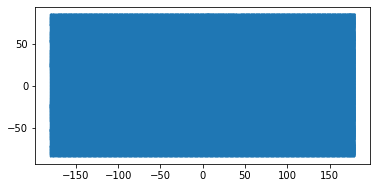

In [3]:
df.boundary.plot()

In [4]:
df['zone'] = df.Name.map(lambda x: x[:3])
df_zones = df.dissolve(by='zone', as_index=False)
df_zones.head()

,zone,geometry,Name
0,01C,MULTIPOLYGON Z (((-180.00000 -82.01866 0.00000...,01CCV
1,01D,MULTIPOLYGON Z (((-179.78352 -72.16587 0.00000...,01DCA
2,01E,MULTIPOLYGON Z (((-178.95196 -64.10055 0.00000...,01ECK
3,01F,MULTIPOLYGON Z (((-178.60505 -56.02263 0.00000...,01FBA
4,01G,MULTIPOLYGON Z (((-178.27353 -47.93369 0.00000...,01GBH


In [5]:
def simplify(geo):
    if isinstance(geo, MultiPolygon):
        for p in geo.geoms:
            #print(type(p))
            if isinstance(p, Polygon):
                #print(p)
                return p
    return geo
        
df_zones_f = df_zones.copy()
df_zones_f.geometry = df_zones_f.geometry.map(simplify)

<AxesSubplot:>

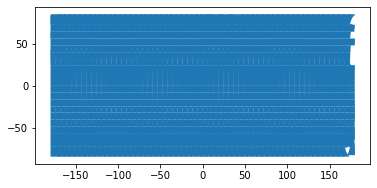

In [6]:
df_zones_f.plot()

In [7]:
df_zones.to_file('s2_zones_0.geojson', driver='GeoJSON')

# Read from Server

Use the shapefile to figure out actual geometries on the site first linked. Wish there was a better way.

In [8]:
from dem_stitcher.rio_window import transform_bounds
from rasterio.crs import CRS

relevant_global_bbox = box(-179, -80, 179, 80)

def generate_url(zone, year=2021):
    assert(year in list(range(2017, 2022)))
    base_url = 'https://lulctimeseries.blob.core.windows.net/lulctimeseriespublic'
    url = f'{base_url}/lc{year}/{zone}_{year}0101-{year+1}0101.tif'
    return url

def get_raster_geo(zone):
    url = generate_url(zone)
    try:
        with rasterio.open(url) as ds:
            bounds = ds.bounds
            src_crs = ds.crs
            bounds_4326 = transform_bounds(bounds,
                                           src_crs, 
                                           CRS.from_epsg(4326))
            
            # weird UTM behavior at dateline - heuristic transformation
            xmin, xmax = bounds_4326[0], bounds_4326[2]
            if xmax < xmin:
                bounds_4326[0] = xmin - 360.
                bounds_4326[2] = xmax
            geo = box(*list(bounds_4326))#.intersection(relevant_global_bbox)
        return geo
    except RasterioIOError:
        return Polygon()

In [9]:
geometries = list(map(get_raster_geo, tqdm(df_zones_f.zone)))

100%|█████████████████████████████████| 1197/1197 [13:35<00:00,  1.47it/s]


In [10]:
df_final = gpd.GeoDataFrame(df_zones_f[['zone']], 
                            geometry = geometries, 
                            crs = CRS.from_epsg(4326))
df_final = df_final[~df_final.geometry.is_empty].reset_index(drop=True)
df_final.head()

,zone,geometry
0,01C,"POLYGON ((-174.00377 -79.97089, -174.00377 -71..."
1,01G,"POLYGON ((-174.00181 -47.98783, -174.00181 -39..."
2,01K,"POLYGON ((-174.00041 -23.99679, -174.00041 -15..."
3,01L,"POLYGON ((-174.00011 -15.99869, -174.00011 -7...."
4,01U,"POLYGON ((-173.41267 47.96096, -173.41267 55.9..."


In [14]:
df_final.to_file('s2_class_zones.geojson', driver='GeoJSON')

<AxesSubplot:>

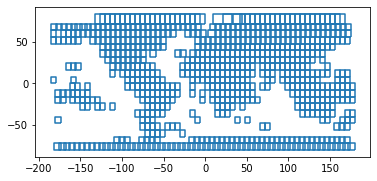

In [15]:
df_final.boundary.plot()